# Data Preparation Tutorial

## Outline
1. What data do we need for SFS-based demographic inference
2. Our Dataset
3. VCF filtering
4. Data quality control 1: PCA
5. Data quality control 2: HWE
6. Hands on!

## 1. What data do we need for SFS-based demographic inference?

- VCF with SNPs data
- As many SNP's as possible
- As many individuals as possible (8-10 okay, 100 better)
- Remove relatives
- Use neutral sites or intergenic regions (similar evolution forces)
- Remove multiallelic, indels
- No MAF-filtering (!)
- ~~Avoid missing data~~ (`easySFS` can help with missing data)

-----
## 2.  Our Dataset

We have a dataset for clouded leopards (*Neofelis nebulosa*). It is an example data for one contig (10,000,000 bp) for 10 diploid individuals (20 haploid samples).

All the data is available in the `data` folder:

In [1]:
%%bash
ls data

biallelic_snps.vcf
example_data.vcf
popmap.txt
pruned_variants.log
pruned_variants.nosex
pruned_variants.prune.in
pruned_variants.prune.out
pruned_variants.vcf


- File `data/example_data.vcf` is our VCF file for all 10 individuals (single chromosome of 10,000,000 bp):

In [2]:
%%bash
# First five lines
head -6 data/example_data.vcf

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##source=tskit 0.5.7
##contig=<ID=CONTIG1,length=10000000>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	Leopard01	Leopard02	Leopard03	Leopard04	Leopard05	Leopard06	Leopard07	Leopard08	Leopard09	Leopard10


In [3]:
%%bash
# The header line of the VCF file (we take first 84 lines of file and then show the last one)
head -6 data/example_data.vcf | tail -1

#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	Leopard01	Leopard02	Leopard03	Leopard04	Leopard05	Leopard06	Leopard07	Leopard08	Leopard09	Leopard10


- File `data/popmap.txt` provides population assignments per individual (all our individuals are from the same population that is marked as `NN`):

In [4]:
%%bash
cat data/popmap.txt

Leopard01 NN
Leopard02 NN
Leopard03 NN
Leopard04 NN
Leopard05 NN
Leopard06 NN
Leopard07 NN
Leopard08 NN
Leopard09 NN
Leopard10 NN


-----
## 3. VCF filtering

We require VCF with biallelic single-nucleotide variants. Having our VCF file we can filter all mutiallelic, multi-nucleotide variants and indels using bcftools:

In [5]:
%%bash
bcftools view -m2 -M2 -v snps data/example_data.vcf -Ov -o data/biallelic_snps.vcf

--------
## 5. Data quality control 1: PCA

Now we will check for the quality of samples. We would run principal component analysis (PCA) to check for the population structure.

### LD pruning
PCA method assumes that input SNPs are independent, so we need to do **LD pruning** first. We will use `plink` for that (the download is available [here](https://www.cog-genomics.org/plink/)).

#### Install `plink`
We are installing plink for Linux system, you can use the following link for MacOS: `https://s3.amazonaws.com/plink1-assets/plink_mac_20250819.zip`.

In [6]:
%%bash
mkdir plink
cd plink
wget https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20250819.zip
unzip plink_linux_x86_64_20250819.zip

--2025-10-15 19:02:01--  https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20250819.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.199.96, 16.15.202.110, 52.217.229.64, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.199.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6321240 (6.0M) [application/zip]
Saving to: ‘plink_linux_x86_64_20250819.zip’

     0K .......... .......... .......... .......... ..........  0%  277K 22s
    50K .......... .......... .......... .......... ..........  1%  554K 16s
   100K .......... .......... .......... .......... ..........  2% 63.2M 11s
   150K .......... .......... .......... .......... ..........  3%  379M 8s
   200K .......... .......... .......... .......... ..........  4%  560K 9s
   250K .......... .......... .......... .......... ..........  4% 89.3M 7s
   300K .......... .......... .......... .......... ..........  5% 37.9M 6s
   350K .......... .......... .......... .......... ..

  5150K .......... .......... .......... .......... .......... 84% 1013M 0s
  5200K .......... .......... .......... .......... .......... 85% 20.0M 0s
  5250K .......... .......... .......... .......... .......... 85% 40.9M 0s
  5300K .......... .......... .......... .......... .......... 86%  650M 0s
  5350K .......... .......... .......... .......... .......... 87%  681M 0s
  5400K .......... .......... .......... .......... .......... 88%  695M 0s
  5450K .......... .......... .......... .......... .......... 89%  710M 0s
  5500K .......... .......... .......... .......... .......... 89%  696M 0s
  5550K .......... .......... .......... .......... .......... 90% 29.5M 0s
  5600K .......... .......... .......... .......... .......... 91%  648M 0s
  5650K .......... .......... .......... .......... .......... 92%  934M 0s
  5700K .......... .......... .......... .......... .......... 93% 45.1M 0s
  5750K .......... .......... .......... .......... .......... 93% 63.5M 0s
  5800K ....

Archive:  plink_linux_x86_64_20250819.zip
  inflating: plink                   
  inflating: LICENSE                 
  inflating: toy.ped                 
  inflating: toy.map                 
  inflating: prettify                


check that `plink` is working:

In [ ]:
%%bash
./plink/plink --help

#### Run LD pruning using `plink`

We are using the following arguments:
- `--vcf` — specifies the location of your VCF file.
- `--double-id`  — sets both family and individual IDs in the PLINK files to your sample ID. This is necessary because PLINK expects separate family and individual IDs (for pedigree analysis), but for most population genetic analyses, duplicating the sample ID is sufficient.
- `--allow-extra-chr` — allows chromosomes beyond the standard human set (1-22, X, Y, MT). This is required if your VCF uses non-human or custom chromosome names.
- `--set-missing-var-ids @:#` — assigns variant IDs in the format chromosome:position when IDs are missing. Many non-human VCFs don't have SNP names, so this ensures PLINK can uniquely identify each variant.
- `--indep-pairwise 50 5 0.1` — performs LD pruning. Here, 50 is the window size in SNPs, 10 is the step size (how far the window advances), and 0.1 is the r² threshold; SNPs with stronger LD than this threshold are pruned out.
- `--out` — sets the prefix for all output files.

In [8]:
%%bash
./plink/plink --vcf data/biallelic_snps.vcf --double-id --allow-extra-chr --set-missing-var-ids @:# --indep-pairwise 50 5 0.1 --out data/pruned_variants

PLINK v1.9.0-b.7.11 64-bit (19 Aug 2025)           cog-genomics.org/plink/1.9/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/pruned_variants.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --indep-pairwise 50 5 0.1
  --out data/pruned_variants
  --set-missing-var-ids @:#
  --vcf data/biallelic_snps.vcf

31799 MB RAM detected; reserving 15899 MB for main workspace.
--vcf: data/pruned_variants-temporary.bed + data/pruned_variants-temporary.bim
+ data/pruned_variants-temporary.fam written.
544032 variants loaded from .bim file.
10 people (0 males, 0 females, 10 ambiguous) loaded from .fam.
Ambiguous sex IDs written to data/pruned_variants.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 10 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737

Now we will convert our pruned variants back to VCF format. Our final file is `data/pruned_variants.vcf`.

In [9]:
%%bash
./plink/plink --vcf data/biallelic_snps.vcf --double-id --allow-extra-chr --set-missing-var-ids @:# --extract data/pruned_variants.prune.in --recode vcf --out data/pruned_variants

PLINK v1.9.0-b.7.11 64-bit (19 Aug 2025)           cog-genomics.org/plink/1.9/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/pruned_variants.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --extract data/pruned_variants.prune.in
  --out data/pruned_variants
  --recode vcf
  --set-missing-var-ids @:#
  --vcf data/biallelic_snps.vcf

31799 MB RAM detected; reserving 15899 MB for main workspace.
--vcf: data/pruned_variants-temporary.bed + data/pruned_variants-temporary.bim
+ data/pruned_variants-temporary.fam written.
544032 variants loaded from .bim file.
10 people (0 males, 0 females, 10 ambiguous) loaded from .fam.
Ambiguous sex IDs written to data/pruned_variants.nosex .
--extract: 10018 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 10 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404

### PCA
We are finally ready to draw PCA plot. You can do it using plink as well, you can find detailed instructions [here](https://speciationgenomics.github.io/pca/). However, today we are going to use custom scripts for that.

To have a nice picture in this notebook we will use the script through python:

In [ ]:
from scripts.draw_pca_plot import pca_plot

# To save to a file:
pca_plot(vcf_file="data/pruned_variants.vcf",
         popmap_file="data/popmap.txt",
         output_file=None,  # output here
         only_full_data=False,  # missing data will be filled with mean values
         double_ids=True,
         show_sample_names=False,  # If True sample names will be pictured on the plot
)

However, you can run script from command line the following way (the same picture will appear if you use it from the command line interface):

In [11]:
%%bash
python scripts/draw_pca_plot.py --help

usage: draw_pca_plot.py [-h] [--full] [--show-sample-names] [--double-ids]
                        vcf popmap [output]

Draw PCA plot from VCF and popmap files.

positional arguments:
  vcf                  VCF filename
  popmap               Popmap filename (tab-separated: sample pop)
  output               Output file for the plot (e.g., pca.png); if omitted,
                       plot will be shown interactively

options:
  -h, --help           show this help message and exit
  --full               Use only full data rows (exclude missing genotypes)
  --show-sample-names  Display sample names on the plot at each point
  --double-ids         VCF contains doubled ids for samples (result of LD
                       pruning using plink)


In [12]:
%%bash
python scripts/draw_pca_plot.py --double-ids --show-sample-names data/pruned_variants.vcf data/popmap.txt my_pca.pdf

[INFO] Reading popmap...
[INFO] 10 samples, 1 populations detected
[INFO] Reading VCF (this might take a while)...
[INFO] Data shape after filtering: (10, 10018)
[INFO] Running PCA...
[INFO] Saving to my_pca.pdf ...
[INFO] Done.


## 5. Data quality control 2: HWE

An additional sanity check is the test for Hardy-Weinberg Equilibrium (HWE). Deviations from HWE (such as a significant excess or deficit of heterozygotes or homozygotes) can indicate genotyping problems.

The HWE principle describes the expected distribution of genotype frequencies (homozygotes and heterozygotes) under conditions of random mating, no selection, and no population structure. In well-behaved, high-quality genetic datasets, most loci are expected to approximately follow these theoretical proportions.

By drawing an HWE ternary plot, we can visually assess whether our data conform to these expectations or if systematic deviations exist. Such deviations may be early warning signs of technical issues in the dataset (for example, genotyping errors, sample contamination, or problematic variants), or reflect biological factors such as inbreeding or population substructure.

<div>
<img src="pictures/HWE_ternary_plot_example.png" width="500" align="left" />
</div>
Source: Graffelman & Camarena (2008)

The paper by [Graffelman & Camarena (2008)](https://doi.org/10.1159/000108939)  describe both statistical tests and graphical tools for assessing Hardy-Weinberg equilibrium. Their paper introduces the use of chi-squared and continuity-corrected chi-squared tests to identify deviations from HWE, and shows how to visualize the **acceptance region**—where genotype frequencies are consistent with HWE at a chosen significance level (e.g., α = 0.05)—on the ternary plot.

Methods from the paper are implemented in [R library `HardyWeinberg`](https://doi.org/10.32614/CRAN.package.HardyWeinberg). The ternary plot is available via the HWTernaryPlot function. For users working with VCF data, files can be loaded into R using the [`vcfR` package](https://doi.org/10.32614/CRAN.package.vcfR). Example result:
<div>
<img src="pictures/Rplot_HWE.png" width="500" align="left" />
</div>

In this tutorial, however, we will use a modified python version of their approach. The solid lines present the acceptance region ($\alpha=0.05$) for HWE based on $\chi^2$ test and dashed lines refer to acceptance region ($\alpha=0.05$) for a $\chi^2$ test with continuity correction.

/home/enoskova/Workspace/GADMA_workshops/2025-10-Demographic_Inference_using_GADMA_Worshop/tutorials/2_data_preparation/scripts/draw_HWE_ternary_plot.py:145: RuntimeWarning: invalid value encountered in sqrt
  delta = np.sqrt(


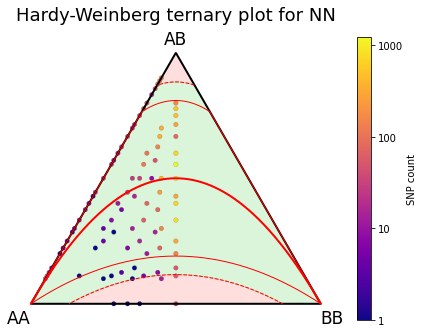

In [13]:
from scripts.draw_HWE_ternary_plot import hwe_ternary_plot

# To save to a file:
hwe_ternary_plot(vcf_file="data/pruned_variants.vcf",
                 popmap_file="data/popmap.txt",
                 population_name="NN"
)

In order to run script from command line:

In [14]:
%%bash
python scripts/draw_HWE_ternary_plot.py --help

usage: draw_HWE_ternary_plot.py [-h] [-o OUTPUT] [--double-ids]
                                vcf popmap population

Draw a Hardy-Weinberg ternary plot for one population using a VCF and popmap.
Green background shows 'inside bounds', red otherwise.

positional arguments:
  vcf                   Input VCF file
  popmap                Popmap file
  population            Population name (as in popmap)

options:
  -h, --help            show this help message and exit
  -o OUTPUT, --output OUTPUT
                        Output file (default: interactive)
  --double-ids          VCF contains doubled ids for samples (result of LD
                        pruning using plink)


In [15]:
%%bash
python scripts/draw_HWE_ternary_plot.py --double-ids --output HWE_ternary_plot.pdf data/pruned_variants.vcf data/popmap.txt NN

/home/enoskova/Workspace/GADMA_workshops/2025-10-Demographic_Inference_using_GADMA_Worshop/tutorials/2_data_preparation/scripts/draw_HWE_ternary_plot.py:145: RuntimeWarning: invalid value encountered in sqrt
  delta = np.sqrt(


[INFO] Saved plot to HWE_ternary_plot.pdf


In [ ]:
-----
## 6. Hands On: Build Folded SFS

Now it is your turn! Can you build a **folded** site frequency spectrum?

You have to perform several steps:
* Run `easySFS` to construct unfolded spectrum
* Print the result SFS
* Draw the result SFS